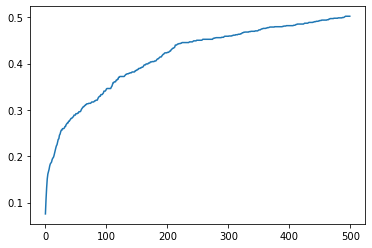

In [1]:
# hard constraints

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

N = 1
T = 500
m = 20  # number of devices
n = 5  # number of servers
y_max = 110
y_min = 90
rs = 0.1
beta = np.ones(n)
beta[0] = 3
beta[1] = 3
seed = 0
np.random.seed(seed)

def optimization(m, n, wS, y, mu, BS, beta, CD):
    x = cp.Variable((n + 1, m), nonneg=True)
    obj = beta @ cp.inv_pos(cp.sqrt(x[1:, :] @ y + wS))

    constraints = [0 <= x, x <= 1,
                   x[1:, :] @ y <= BS,
                   cp.sum(x, 0) == 1]
    for i in range(m):
        constraints.append((y[i] * mu[i, :] @ x[1:, i]) <= CD[i])

    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve()  # Returns the optimal value.
    return x, prob

def oracle(y, mu):
    x, prob = optimization(m, n, wS, y, mu, BS, beta, CD)
    return x.value, prob.value, prob.status

def f(x, y):
    return beta.dot(1/np.sqrt(x[1:, :].dot(y) + wS))

def f_drop(x, y, mu, CD, BS):
    yp = np.minimum(y, CD/ np.diag(mu @ x[1:, :]))
    dp = np.minimum(x[1:, :].dot(yp), BS)
    return beta.dot(1/np.sqrt(dp + wS))

reg = np.zeros((N, T))

#records all y, x_opt, x_t #yuhang yao
y_N_T = np.zeros((N, T, m)) #yuhang yao
x_opt_N_T = np.zeros((N, T, n + 1, m)) #yuhang yao
x_t_N_T = np.zeros((N, T, n + 1, m)) #yuhang yao
j_N_T = np.zeros((N, T, m))#yuhang yao
BS_N = np.zeros((N, n))#yuhang yao

for u in range(N):
    wS = np.random.randint(15, 25, n)
    
#     BS = np.random.uniform(y_min*5, y_max*5, n)
#     CD = np.random.uniform(y_min/2, y_max/2, m)
    BS = np.random.uniform(y_min*10, y_max*10, n)
    BS_N[u] = BS
    CD = np.random.uniform(y_min*0.7, y_max*0.7, m)
    mu = np.random.rand(m, n)
    mu[:,0] = 0.5
    mu[:,1] = 0.5
    mu[:,2] = 0.8
    mu[:,3] = 0.8
    mu[:,4] = 0.8
    # trace_gen = Trace(m, n, seed + u)
    # mu = trace_gen.avg()
    # mu = np.random.rand(m, n)
    # mu_hat = np.zeros_like(mu)  # empirical mean
    mu_hat = np.ones_like(mu)
    T_ij = np.ones_like(mu)  # total number of times arm (i,j) is played
    for t in range(T):
        y = np.random.uniform(y_min, y_max, m).astype(int)
        x_opt, f_opt, status = oracle(y, mu)
        if 'optimal' not in status:
            print('Solution infeasible 1')
            break

        rho_ij = np.sqrt(3 * np.log(t + 1) / (2 * T_ij)) * rs
        mu_bar = np.maximum(mu_hat - rho_ij, 0) # LCB
        x_tmp, f_tmp, status = oracle(y, mu_bar)
        if 'optimal' not in status:
            print('Solution infeasible 2')
            break
        
        # mapping from x_tmp to x_t (new)
        x_t = np.zeros((n + 1, m))
        
        for i in range(m):
            cost = y[i] * mu[i,:].dot(x_tmp[1:, i])
            if cost > CD[i]:
                x_t[1:, i] = mu_bar[i] / mu[i] * x_tmp[1:, i]
                x_t[0, i] = 1-np.sum(x_t[1:, i])
                if x_t[0, i] < 0:
                    x_t[0, i] = 0
                    x_t[1:, i] = x_t[1:, i]/np.sum(x_t[1:, i])
            else:
                x_t[:, i] = x_tmp[:, i]

        f_t = f(x_t, y)
        
        # sample j based on x_t[i], observe c_ij, update mu_hat[i,j]
        # c = trace_gen.generate()
        for i in range(m):
            j = np.random.choice(n+1, p=x_t[:, i])
            j_N_T[u, t, i] = j #yuhang yao
            if j != 0:
                j -= 1
                c_ij = int(np.random.rand() < mu[i, j])
                # a = np.random.rand() * 3
                # c_ij = np.random.beta(a, a * (1-mu[i, j])/mu[i, j]) # beta distribution
                # c_ij = c[i, j]  # trace
                T_ij[i, j] += 1
                mu_hat[i, j] += (c_ij - mu_hat[i, j]) / T_ij[i, j]

        # calculate regert
        reg[u, t] = f_t - f_opt
        y_N_T[u, t] = y#yuhang yao
        x_opt_N_T[u, t] = x_opt#yuhang yao
        x_t_N_T[u, t] = x_t#yuhang yao
        
plt.plot(np.cumsum(reg, axis=1).T)

In [2]:
x_t[1:, :].dot(y) + wS

array([605.70735018, 605.70937788, 291.19441505, 291.19444473,
       291.19441143])

In [3]:
x_opt[1:, :].dot(y) + wS

array([605.71613982, 605.70536136, 291.19407864, 291.1941644 ,
       291.19024448])

In [4]:
np.sum((y*x_t[1:]).T*mu)

1240.6749809965972

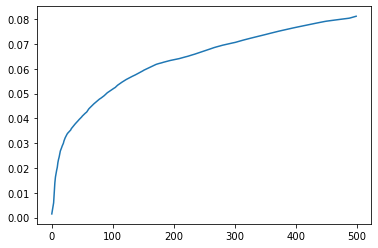

In [10]:
# soft constraints

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

N = 1
T = 500
m = 20  # number of devices
n = 5  # number of servers
y_max = 110
y_min = 90
rs = 0.1
beta = np.ones(n)
beta[0] = 3
beta[1] = 3
gamma = 0.0001

def optimization(m, n, wS, y, mu, BS, beta):
    x = cp.Variable((n + 1, m), nonneg=True)
    obj = beta @ cp.inv_pos(cp.sqrt(x[1:, :] @ y + wS)) + gamma * cp.sum(cp.multiply(cp.diag(mu @ x[1:, :]), y))

    constraints = [0 <= x, x <= 1,
                   x[1:, :] @ y <= BS,
                   cp.sum(x, 0) == 1]

    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve()  # Returns the optimal value.
    return x, prob

def oracle(y, mu):
    x, prob = optimization(m, n, wS, y, mu, BS, beta)
    return x.value, prob.value, prob.status

def f(x, y, mu):
    return beta.dot(1/np.sqrt(x[1:, :].dot(y) + wS)) + gamma * np.sum((y*x[1:]).T*mu)

def f_drop(x, y, mu, BS, gamma):
    dp = np.minimum(x[1:, :].dot(y), BS)
    return beta.dot(1/np.sqrt(dp + wS)) + gamma * np.sum((y*x[1:]).T*mu)

reg = np.zeros((N, T))

#records all y, x_opt, x_t #yuhang yao
y_N_T = np.zeros((N, T, m)) #yuhang yao
x_opt_N_T = np.zeros((N, T, n + 1, m)) #yuhang yao
x_t_N_T = np.zeros((N, T, n + 1, m)) #yuhang yao
j_N_T = np.zeros((N, T, m))#yuhang yao
BS_N = np.zeros((N, n))#yuhang yao

for u in range(N):
    wS = np.random.randint(15, 25, n)
    BS = np.random.uniform(y_min*10, y_max*10, n)
    BS_N[u] = BS
    mu = np.random.rand(m, n)
    mu[:,0] = 0.5
    mu[:,1] = 0.5
    mu[:,2] = 0.8
    mu[:,3] = 0.8
    mu[:,4] = 0.8
    # trace_gen = Trace(m, n, seed + u)
    # mu = trace_gen.avg()
    # mu = np.random.rand(m, n)
    # mu_hat = np.zeros_like(mu)  # empirical mean
    mu_hat = np.zeros_like(mu)
    T_ij = np.ones_like(mu)  # total number of times arm (i,j) is played
    for t in range(T):
        y = np.random.uniform(y_min, y_max, m).astype(int)
        x_opt, f_opt, status = oracle(y, mu)
        if 'optimal' not in status:
            print('Solution infeasible 1')
            break

        rho_ij = np.sqrt(3 * np.log(t + 1) / (2 * T_ij)) * rs
        mu_bar = np.maximum(mu_hat - rho_ij, 0) # LCB
        x_t, _, status = oracle(y, mu_bar)
        if 'optimal' not in status:
            print('Solution infeasible 2')
            break

        f_t = f(x_t, y, mu)

        # sample j based on x_t[i], observe c_ij, update mu_hat[i,j]
        # c = trace_gen.generate()
        for i in range(m):
            j = np.random.choice(n+1, p=x_t[:, i])
            j_N_T[u, t, i] = j #yuhang yao
            if j != 0:
                j -= 1
                c_ij = int(np.random.rand() < mu[i, j])
                # a = np.random.rand() * 3
                # c_ij = np.random.beta(a, a * (1-mu[i, j])/mu[i, j]) # beta distribution
                # c_ij = c[i, j]  # trace
                T_ij[i, j] += 1
                mu_hat[i, j] += (c_ij - mu_hat[i, j]) / T_ij[i, j]

        # calculate regert
        reg[u, t] = f_t - f_opt
        y_N_T[u, t] = y#yuhang yao
        x_opt_N_T[u, t] = x_opt#yuhang yao
        x_t_N_T[u, t] = x_t#yuhang yao
        
plt.plot(np.cumsum(reg, axis=1).T)

In [12]:
beta.dot(1/np.sqrt(x_t[1:, :].dot(y) + wS))

0.4212202218464382

In [13]:
x_t[1:, :].dot(y) + wS

array([647.11743944, 636.9302228 , 262.27559505, 263.05699937,
       268.61974145])

In [14]:
x_t[1:, :].dot(y) + wS

array([647.11743944, 636.9302228 , 262.27559505, 263.05699937,
       268.61974145])

In [15]:
s = 0
for i in range(m):
    for j in range(n):
        s += mu[i,j]*x_t[j+1,i]*y[i]
s

1207.3856998158342